In [ ]:
"""Run two below lines to get my_abc module"""
# !git clone https://github.com/thanhttttt/thanh.git
# !pip install -r /content/thanh/requirements.txt
"""Run two below lines to drive"""
# from google.colab import drive
# drive.mount('/content/drive')

# Import libs

In [ ]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import sys
sys.path.append('../')
sys.path.append('/content/thanh/')
sys.path.append('../thanh/')
import sionna

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation

# Load the required Sionna components
from sionna.nr.my_abc import *

# Load model weights

In [4]:
_model = CustomNeuralReceiver(training = False)
inputs = tf.zeros([1,48,14,18])
_model(inputs)
_model.summary()

#load_weights(_model, '/content/drive/MyDrive/Pusch_data/Model_weights/model_weight_FULL_RB_epoch_40.pkl')
# load_weights(_model, '../model_weight_FULL_RB_epoch_40.pkl')
load_weights(_model, '../weight_4RB_UMI_dynamic_config.pkl')

Model: "custom_neural_receiver"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  20864     
                                                                 
 residual_block (ResidualBl  multiple                  639232    
 ock)                                                            
                                                                 
 residual_block_1 (Residual  multiple                  639232    
 Block)                                                          
                                                                 
 residual_block_2 (Residual  multiple                  639232    
 Block)                                                          
                                                                 
 residual_block_3 (Residual  multiple                  639232    
 Block)                                     

# Setup pusch config

In [5]:
RB_start = 0
NRB = 162
PCI = 666
RNTI = 55555
MCS = 8

In [6]:
sysCfg = SystemConfig(
    NCellId = PCI,
    Numerology = 1,
    BwpNRb = 162
)
ueCfg = UeConfig(
    TransformPrecoding = 0,
    Rnti = RNTI,
    nId = PCI,
    CodeBookBased = 0,
    DmrsPortSetIdx = [0],
    NLayers = 1,
    NumDmrsCdmGroupsWithoutData = 2,
    Tpmi = 0,
    FirstSymb = 0,
    NPuschSymbAll = 14,
    RaType = 1,
    FirstPrb = RB_start,
    NPrb = NRB,
    FrequencyHoppingMode = 0,
    McsTable = 0,
    Mcs = MCS,
    ILbrm = 0,
    nScId = 0,
    NnScIdId = PCI,
    DmrsConfigurationType = 0,
    DmrsDuration = 1,
    DmrsAdditionalPosition = 1,
    PuschMappingType = 0,
    DmrsTypeAPosition = 3,
    HoppingMode = 0,
    NRsId = 0,
    Ptrs = 0,
    ScalingFactor = 0,
    OAck = 0,
    IHarqAckOffset = 11,
    OCsi1 = 0,
    ICsi1Offset = 7,
    OCsi2 = 0,
    ICsi2Offset = 0,
    NPrbOh = 0,
    nCw = 1,
    TpPi2Bpsk = 0
)
myCfg = MyConfig(sysCfg, [ueCfg])
puschCfg = MyPUSCHConfig(myCfg, 4)
puschCfg.show()

Carrier Configuration
cyclic_prefix : normal
cyclic_prefix_length : 2.3437500000000002e-06
frame_duration : 0.01
frame_number : 0
kappa : 64.0
mu : 1
n_cell_id : 666
n_size_grid : 162
n_start_grid : 0
num_slots_per_frame : 20
num_slots_per_subframe : 2
num_symbols_per_slot : 14
slot_number : 4
sub_frame_duration : 0.001
subcarrier_spacing : 30
t_c : 5.086263020833334e-10
t_s : 3.2552083333333335e-08

PUSCH Configuration
My_Config : MyConfig(Sys=SystemConfig(NCellId=666, FrequencyRange=1, BandWidth=60, Numerology=1, CpType=0, NTxAnt=1, NRxAnt=8, BwpNRb=162, BwpRbOffset=0, harqProcFlag=0, nHarqProc=1, rvSeq=0), Ue=[UeConfig(TransformPrecoding=0, Rnti=55555, nId=666, CodeBookBased=0, DmrsPortSetIdx=[0], NLayers=1, NumDmrsCdmGroupsWithoutData=2, Tpmi=0, FirstSymb=0, NPuschSymbAll=14, RaType=1, FirstPrb=0, NPrb=162, FrequencyHoppingMode=0, McsTable=0, Mcs=8, ILbrm=0, nScId=0, NnScIdId=666, DmrsConfigurationType=0, DmrsDuration=1, DmrsAdditionalPosition=1, PuschMappingType=0, DmrsTypeAPositi

# E2E Model

In [9]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sionna.config.xla_compat=True

class E2EModel(tf.keras.Model):
    def __init__(self, pusch_config: MyPUSCHConfig, decoding_scenario: str, channel_scenario: str, model = None):
        super().__init__()

        assert decoding_scenario in ['perfect-csi', 'ls-without-prior', 'neural-receiver', 'openvino-model']
        self.decoding_scenario = decoding_scenario
        channel_scenario = channel_scenario.split('-')
        assert len(channel_scenario) == 4
        (chnl, ml, ds, spd) = channel_scenario
        ds = int(ds)
        spd = int(spd)
        assert chnl == 'CDL'

        self.pusch_config = pusch_config

        self.simulator = MySimulator(pusch_config)
        channel_model = CDL(model = ml,
                            delay_spread = ds*1e-9,
                            carrier_frequency = CARRIER_FREQUENCY,
                            ut_array = Ue_Antenna,
                            bs_array = Gnb_AntennaArray,
                            direction = 'uplink',
                            min_speed = spd,
                            max_speed = spd)
        
        self.channel = OFDMChannel(channel_model=channel_model, resource_grid=self.simulator.resource_grid,
                                            add_awgn=False, normalize_channel=True, return_channel=True)

        if decoding_scenario in ['neural-receiver']:
            self.model = model

    @tf.function(jit_compile=None)
    def call(self, batch_size, ebno_db):

        no = ebnodb2no(ebno_db,
                    self.pusch_config.tb.num_bits_per_symbol,
                    self.pusch_config.tb.target_coderate,
                    self.simulator.resource_grid)
        
        b, c, y, _ ,h = self.simulator.sim(batch_size, self.channel, no, return_tx_iq=True, return_channel=True)
        r = self.simulator.ref(batch_size)

        if self.decoding_scenario == 'neural-receiver':
            preds = predict(self.model, y, r)
            llr_layer = tf.reshape(preds, [-1, NUM_TX, c.shape[-1]])
            b_hat,_ = self.simulator.TB_Decode(llr_layer)
        
        else:
            if 'ls-without-prior' == self.decoding_scenario:
                _, _, _, b_hat, _ = self.simulator.rec(y)
            elif 'perfect-csi':
                _, _, _, b_hat, _ = self.simulator.per(y,h,no)

        return b, b_hat       

XLA can lead to reduced numerical precision. Use with care.


# Pusch sim scenarios

In [13]:
# Select scenarios for simulation
channel_scenarios = ['CDL-C-150-10', 'CDL-E-350-50']  #     Form: [Channel_type(CDL-A/B/C/D/E)-delay_spread(ns)-speed]
decoding_scenarios = ['neural-receiver', 'ls-without-prior', 'perfect-csi']

# Custom config (ebno range, batch test, num_target_block_errors, max_mc_iter)
PUSCH_SIMS = {
    "channel_scenarios": channel_scenarios,
    "decoding_scenarios": decoding_scenarios,
    "bler" : [],
    "ber" : [],
    "ebno_dbs": list(np.arange(-10., 5.1, 1.)),
    "batch_size": 4,
    "num_target_block_errors": 32,
    "max_mc_iter": 32,
    "duration": 0
    }

start = time.time()
for channel_scenario in PUSCH_SIMS['channel_scenarios']:
    print('Channel scenario: ', channel_scenario)
    for decoding_scenario in PUSCH_SIMS['decoding_scenarios']:
        print('Decoding_scenario: ', decoding_scenario)
        e2e = E2EModel(pusch_config=puschCfg,
                       decoding_scenario=decoding_scenario,
                       channel_scenario=channel_scenario,
                       model=_model)
        ber, bler = sim_ber(e2e, PUSCH_SIMS['ebno_dbs'],
                            batch_size=PUSCH_SIMS["batch_size"],
                            num_target_block_errors=PUSCH_SIMS["num_target_block_errors"],
                            max_mc_iter=PUSCH_SIMS["max_mc_iter"],
                            early_stop=True)
        PUSCH_SIMS["ber"].append(list(ber.numpy()))
        PUSCH_SIMS["bler"].append(list(bler.numpy()))
PUSCH_SIMS["duration"] = time.time() - start

Channel scenario:  CDL-C-150-10
Decoding_scenario:  neural-receiver
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.3685e-01 | 1.0000e+00 |      298108 |      884992 |           32 |          32 |        77.7 |reached target block errors
     -9.0 | 3.0863e-01 | 1.0000e+00 |      273137 |      884992 |           32 |          32 |        41.6 |reached target block errors
     -8.0 | 2.7522e-01 | 1.0000e+00 |      243565 |      884992 |           32 |          32 |        41.7 |reached target block errors
     -7.0 | 2.2995e-01 | 1.0000e+00 |      203507 |      884992 |           32 |          32 |        41.3 |reached target block errors
     -6.0 | 2.0169e-01 | 1.0000e+00 |      178495 |      884992 |           32 |          32 |        41.7 |reached target block erro

Simulation duration: 0.68 [h]


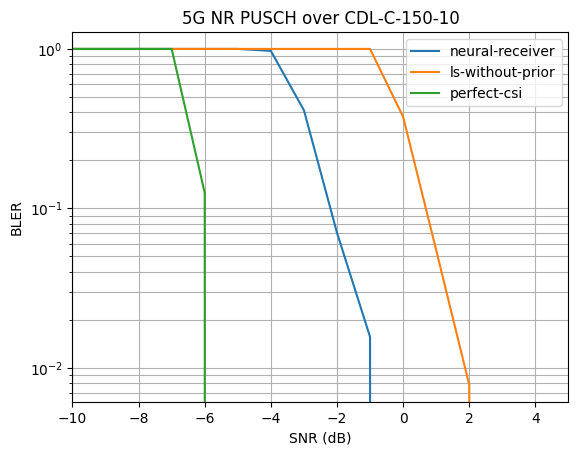

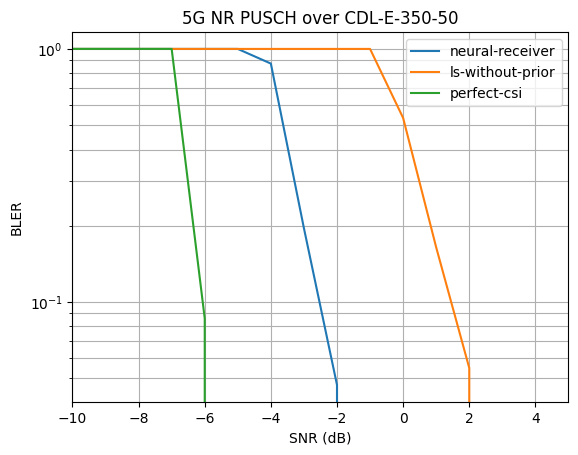

In [ ]:
print("Simulation duration: {:1.2f} [h]".format(PUSCH_SIMS["duration"]/3600))
for j, channel in enumerate(PUSCH_SIMS['channel_scenarios']):
    plt.figure()
    plt.title(f"5G NR PUSCH over {channel}")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BLER")
    plt.grid(which="both")
    plt.xlim([PUSCH_SIMS['ebno_dbs'][0], PUSCH_SIMS['ebno_dbs'][-1]])
    # plt.ylim([1e-5, 1.0])

    legend = []
    for i, decoding_scenario in enumerate(PUSCH_SIMS['decoding_scenarios']):
        plt.semilogy(PUSCH_SIMS['ebno_dbs'], PUSCH_SIMS["bler"][j * len(PUSCH_SIMS['decoding_scenarios']) + i], label=decoding_scenario)

    plt.legend()
    plt.show()

Simulation duration: 0.68 [h]


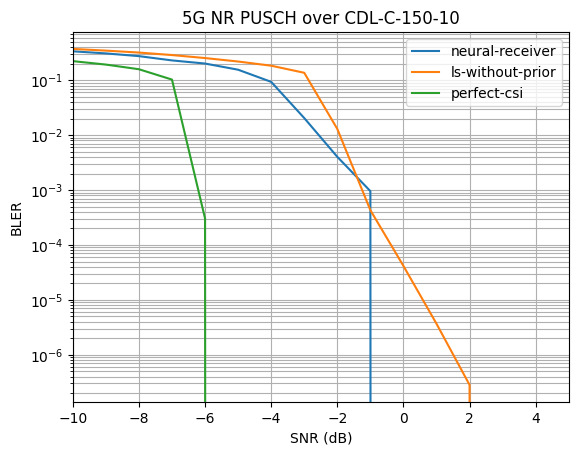

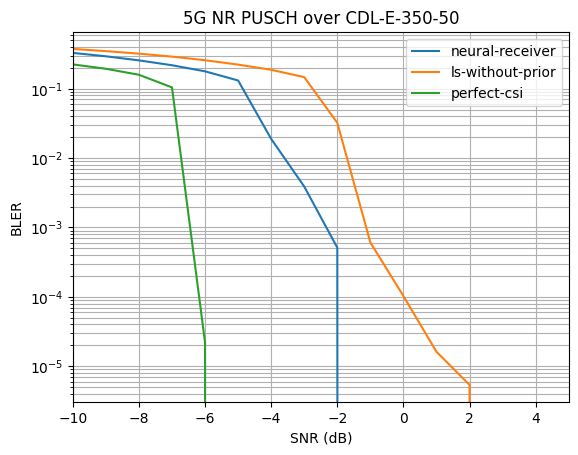

In [ ]:
print("Simulation duration: {:1.2f} [h]".format(PUSCH_SIMS["duration"]/3600))
for j, channel in enumerate(PUSCH_SIMS['channel_scenarios']):
    plt.figure()
    plt.title(f"5G NR PUSCH over {channel}")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BLER")
    plt.grid(which="both")
    plt.xlim([PUSCH_SIMS['ebno_dbs'][0], PUSCH_SIMS['ebno_dbs'][-1]])
    # plt.ylim([1e-5, 1.0])

    legend = []
    for i, decoding_scenario in enumerate(PUSCH_SIMS['decoding_scenarios']):
        plt.semilogy(PUSCH_SIMS['ebno_dbs'], PUSCH_SIMS["ber"][j * len(PUSCH_SIMS['decoding_scenarios']) + i], label=decoding_scenario)

    plt.legend()
    plt.show()